---
<h1><center> Capstone - Manu Mathew </center></h1>

--- 

## Packages Used:

In [12]:

import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns
%pylab inline
pylab.rcParams['figure.figsize'] = (16.0, 4)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


plt.rcParams["axes.titlesize"] = 15
plt.rcParams["legend.fontsize"] = 6
plt.rcParams.update({'font.size': 12})

Populating the interactive namespace from numpy and matplotlib


## Info on Data Files:

## Preprocessing: Loading data and removing columns



In [2]:
#Code for loading in data checking its shape
import pandas as pd
realestate_df = pd.read_csv("MLS_data.csv")
df=realestate_df.drop(['One_Storey_HPI','Two_Storey_HPI','Single_Family_Benchmark','One_Storey_Benchmark','Two_Storey_Benchmark','apartment_pc','detached_PC','townhouse_pc'],axis=1)


## Creating Percentage change columns as dependant variable

In [3]:
df['per_apartment']=0
df['per_detached']=0
df['per_townhouse']=0
for i in range(1,168):
    df.loc[i,'per_apartment']=(df.loc[i,'Apartment_Benchmark']-df.loc[i-1,'Apartment_Benchmark'])/df.loc[i-1,'Apartment_Benchmark']*100
    df.loc[i,'per_detached']=(df.loc[i,'Detached']-df.loc[i-1,'Detached'])/df.loc[i-1,'Detached']*100
    df.loc[i,'per_townhouse']=(df.loc[i,'Townhouse_Benchmark']-df.loc[i-1,'Townhouse_Benchmark'])/df.loc[i-1,'Townhouse_Benchmark']*100

## Defining independent and dependant variables

In [4]:
dep=df['per_detached']#detached house percentage change- dependent variable
dep_apartment=df['per_apartment']#Apartments percentage change- dependent variable
dep_townhouse=df['per_townhouse']#Townhomes percentage change- dependent variable
ind=df.iloc[:,5:30]#Independent Variables

In [5]:
df.head()

,Date,detached HPI,Townhouse_HPI,Apartment_HPI,Detached,Townhouse_Benchmark,Apartment_Benchmark,Population Intrapolated,Unemployment,Prime Rate,...,Dollar Volume,days in market,price per sqft,new listings,no of sales,sales/active ratio,Unnamed: 33,per_apartment,per_detached,per_townhouse
0,01/01/2005,100.00,100.0,100.0,543100,314200,249200,2173374.00,6.3,4.25,...,648808485,48,222,3357,1714.0,0.172,NaN,0.000000,0.000000,0.000000
1,01/02/2005,100.45,100.5,100.8,545300,315800,251200,2175445.75,6.3,4.25,...,1188350508,26,231,4134,3088.0,0.302,NaN,0.802568,0.405082,0.509230
2,01/03/2005,100.85,101.1,101.6,548000,317600,253200,2177517.50,6.4,4.25,...,1631648403,24,239,5111,3961.0,0.379,NaN,0.796178,0.495140,0.569981
3,01/04/2005,101.30,101.7,102.3,550200,319500,254900,2179589.25,6.6,4.25,...,1681998034,19,239,5840,4051.0,0.358,NaN,0.671406,0.401460,0.598237
4,01/05/2005,102.50,102.8,104.1,556700,323000,259400,2181661.00,6.4,4.25,...,1878522245,19,249,5131,4465.0,0.402,NaN,1.765398,1.181389,1.095462


## Entire Input Dependent Variables

In [6]:

Y_train=dep.iloc[0:156]

X_train = ind.loc[0:155,['Population Intrapolated',
       'Unemployment', 'Prime Rate', 'GDP', 'CPI', 'Foreign Buyers Tax',
       'Household Income', 'Per capita Income', 'Stress Test',
       'First Time Home Buyer Downpayment', 'Inflation',
       'cad to usd exchange rates', 'Dollar Volume', 'days in market',
       'price per sqft', 'new listings', 'no of sales', 'sales/active ratio']]
Y_test=dep.iloc[156:168]
X_test = ind.loc[156:168,['Population Intrapolated',
       'Unemployment', 'Prime Rate', 'GDP', 'CPI', 'Foreign Buyers Tax',
       'Household Income', 'Per capita Income', 'Stress Test',
       'First Time Home Buyer Downpayment', 'Inflation',
       'cad to usd exchange rates', 'Dollar Volume', 'days in market',
       'price per sqft', 'new listings', 'no of sales', 'sales/active ratio']]


# Detached Homes Modelling

In [7]:
#Train/Validation/Test Split
Y_train=dep.iloc[0:144]
X_train = ind.loc[0:143,['Population Intrapolated',
        'Prime Rate',  'CPI','Unemployment',
        'Per capita Income',  
        'cad to usd exchange rates','no of sales' ]]
Y_valid=dep.iloc[144:156]
X_valid = ind.loc[144:155,['Population Intrapolated',
        'Prime Rate', 'CPI','Unemployment',
        'Per capita Income',  
        'cad to usd exchange rates','no of sales']]
Y_test=dep.iloc[156:192]
X_test = ind.loc[156:191,['Population Intrapolated',
        'Prime Rate','CPI','Unemployment',
        'Per capita Income', 
        'cad to usd exchange rates','no of sales']]
#Scaling
scaler=MinMaxScaler()
norm_train=scaler.fit_transform(X_train)
norm_valid=scaler.transform(X_valid)
norm_test=scaler.transform(X_test)

### Validation and optimum hyperparameter selection based on minimum mean squared error.

In [10]:
learning=[.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
depth=[1,2,3,4,5,6,7,8,9,10]
valid_list=[]
parameter_list=[]

for i in learning:
    for j in depth:

    
        model=XGBRegressor(learning_rate=i,max_depth=j,n_estimators=1000,random_state=1)
        model.fit(norm_train,Y_train)
        validation=model.predict(norm_valid) 
        valid_mse=mean_squared_error(Y_valid,validation)
        parameter_list.append((i,j))
        print(i,j,valid_mse)
        valid_list.append(valid_mse)
        
#Finding learning rate and depth corresponding to Minimum Mean Squared Error
optimum_error_pos= valid_list.index(min(valid_list))
optimum_order=parameter_list[optimum_error_pos]
optimum_i=optimum_order[0]
optimum_j=optimum_order[1]
print('min_mse_validation:',min(valid_list))
print('optimum_learning rate:',optimum_i)
print('optimum_depth:',optimum_j)

0.01 1 1.3534074166704626
0.01 2 0.7090922549330382
0.01 3 0.6350954455942154
0.01 4 0.8638688909702044
0.01 5 0.805744666354547
0.01 6 0.9142986837308799
0.01 7 0.9214822712240375
0.01 8 0.9441804374732911
0.01 9 1.0244587459726837
0.01 10 1.0961114966801626
0.1 1 1.4395749910514093
0.1 2 0.9642271953336005
0.1 3 0.6287360876331033
0.1 4 0.7582304445054687
0.1 5 0.9956192028305932
0.1 6 0.9054699999485267
0.1 7 1.107364463869729
0.1 8 1.0422799482619887
0.1 9 1.223477531646685
0.1 10 1.1969540103883756
0.2 1 1.5005931441218896
0.2 2 0.8016267046274678
0.2 3 0.6661345409916336
0.2 4 0.9614476945405811
0.2 5 0.9480920108892169
0.2 6 0.951536491290215
0.2 7 0.9501313988946207
0.2 8 1.1568056728269525
0.2 9 1.015989665583834
0.2 10 1.056614473373042
0.3 1 1.3266986741948548
0.3 2 1.181531152172789
0.3 3 0.6758481483652367
0.3 4 0.6427736976320261
0.3 5 0.9048615248441361
0.3 6 0.7729220983308108
0.3 7 0.8838632613262969
0.3 8 0.7902510514164526
0.3 9 0.9370738645424915
0.3 10 0.9624303746

### Rerun model with the best hyperparameter and plotting

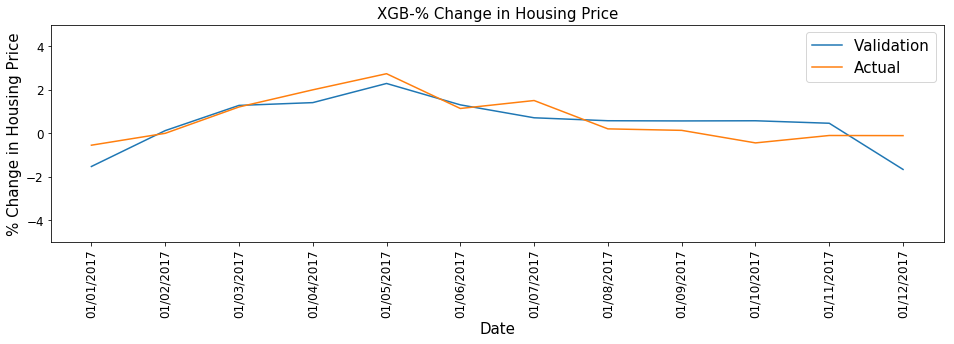

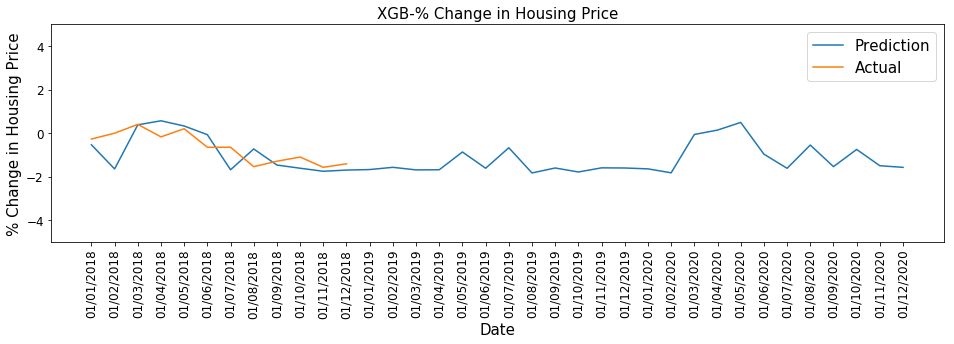

In [13]:
final_model=XGBRegressor(learning_rate=optimum_i,max_depth=optimum_j,n_estimators=1000,random_state=1)
final_model.fit(norm_train,Y_train)
prediction=final_model.predict(norm_test)
validation=final_model.predict(norm_valid)



#Validation Plot
valid_df=pd.DataFrame(validation)
date_v=df.loc[144:155,['Date']]
Y_tv=dep.iloc[144:156]

plt.plot(date_v['Date'],valid_df.loc[:,:],label='Validation')
plt.plot(date_v['Date'],Y_tv.loc[:],label='Actual')
plt.xticks(date_v['Date'], rotation='vertical')
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Change in Housing Price',fontsize=15)
plt.title('XGB-% Change in Housing Price')
plt.ylim(-5,5)
plt.xticks(rotation='vertical')
plt.legend(fontsize=15)
plt.show()

#Prediction plot
pred_df=pd.DataFrame(prediction)
date_p=df.loc[156:191,['Date']]
date_pa=df.loc[156:167,['Date']]
Y_tp=dep.iloc[156:168]

plt.plot(date_p['Date'],pred_df.loc[:,:],label='Prediction')
plt.plot(date_pa['Date'],Y_tp.loc[:],label='Actual')
plt.xticks(date_p['Date'], rotation='vertical')
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Change in Housing Price',fontsize=15)
plt.title('XGB-% Change in Housing Price')
plt.ylim(-5,5)
plt.xticks(rotation='vertical')
plt.legend(fontsize=15)
plt.show()


### Creating results dataframe and plotting percentage change in housing prices

,pred_per_change,real_per_change,Date,pred_hp,real_hp,PCHP_sav/app_model,PCHP_sav/app_actual
0,-0.531847,-0.268197,01/01/2018,1.594773e+06,1599000.0,-0.531847,-0.268197
1,-1.642951,0.000000,01/02/2018,1.568572e+06,1599000.0,-2.166059,-0.268197
2,0.385516,0.406504,01/03/2018,1.574619e+06,1605500.0,-1.788894,0.137217
3,0.571241,-0.168172,01/04/2018,1.583614e+06,1602800.0,-1.227872,-0.031186
4,0.331102,0.205890,01/05/2018,1.588857e+06,1606100.0,-0.900835,0.174640
5,-0.067203,-0.647531,01/06/2018,1.587789e+06,1595700.0,-0.967433,-0.474022
6,-1.681355,-0.645485,01/07/2018,1.561093e+06,1585400.0,-2.632523,-1.116447
7,-0.724296,-1.539044,01/08/2018,1.549786e+06,1561000.0,-3.337751,-2.638308
8,-1.464390,-1.287636,01/09/2018,1.527091e+06,1540900.0,-4.753264,-3.891973
9,-1.610605,-1.096762,01/10/2018,1.502496e+06,1524000.0,-6.287313,-4.946049


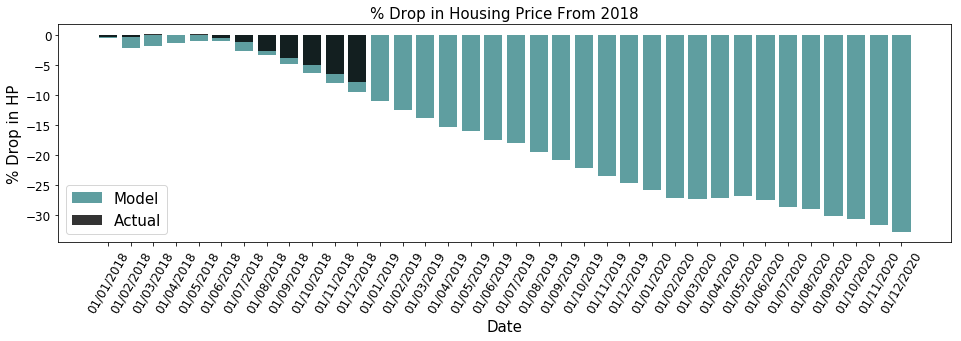

In [14]:

#Creating results Dataframe
date=df.loc[156:191,['Date']].reset_index(drop=True)
real=Y_tp.reset_index()
results=pd.concat([pred_df,real,date],axis=1,join='outer',ignore_index=True)
res=results.drop(1,axis=1)
res['pred_hp']=df.loc[155,'Detached']+(df.loc[155,'Detached']*(res.iloc[0:1,0])/100)
res['real_hp']=df.loc[155,'Detached']+(df.loc[155,'Detached']*(res.iloc[0:1,1])/100)
f_results=res.rename(columns={0:'pred_per_change',2:'real_per_change',3:'Date'})

#Looping to find the housing price each month from 2018 beginning
for i in range (1,36):
    f_results.loc[i,['pred_hp']]=f_results.loc[i-1,['pred_hp']]+(f_results.loc[i-1,['pred_hp']]*(f_results.iloc[i,0]/100))
for i in range (1,12):
    f_results.loc[i,['real_hp']]=f_results.loc[i-1,['real_hp']]+(f_results.loc[i-1,['real_hp']]*(f_results.iloc[i,1]/100))
    
#Calculating the percentage drop of housing price from 2018 beginning
f_results['PCHP_sav/app_model']=((f_results['pred_hp']-df.loc[155,'Detached'])/df.loc[155,'Detached'])*100
f_results['PCHP_sav/app_actual']=((f_results['real_hp']-df.loc[155,'Detached'])/df.loc[155,'Detached'])*100

#plotting housing price percentag drop from 2018-2021
plt.bar(f_results.iloc[:,2],f_results['PCHP_sav/app_model'],label='Model',alpha=1,color='cadetblue')
plt.bar(f_results.iloc[0:12,2],f_results.iloc[0:12,6],label='Actual',alpha=0.8,color='black')
plt.xticks(rotation=60)
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Drop in HP',fontsize=15)
plt.title('% Drop in Housing Price From 2018')
plt.legend(fontsize=15)
plt.savefig('Detached_Result.png')


f_results.head(12)


## Housing prices drop by 32% by 2021 end based on Bank of Canada forecast

# APARTMENTS XGB

0.01 1 1.6540871298725166 0.7167365624427398
0.01 2 0.9700516367685855 0.7120018465692508
0.01 3 0.7160216415441024 0.6508636430188757
0.01 4 1.2506338018773844 0.6568317607287475
0.01 5 1.0424859273957 0.6081903126933074
0.01 6 1.150931806130883 0.623996238484103
0.01 7 1.131259249665063 0.5775193130610773
0.01 8 1.3597617632755066 0.6160041656052809
0.01 9 1.3575827818814272 0.6220306003138135
0.01 10 1.4007552115532809 0.6150305077323174
0.1 1 2.145591124633451 0.9479207359843215
0.1 2 1.0118145762309532 1.0296297402751844
0.1 3 0.6522310586558726 0.6627850758670939
0.1 4 1.0908625903539908 0.6724195445523401
0.1 5 0.9928300215237477 0.5956078420389598
0.1 6 1.1363965693965896 0.6030537053387086
0.1 7 1.1676550497321638 0.5836599184005584
0.1 8 1.2695782253812642 0.6102113707826419
0.1 9 1.2805575277948271 0.6069576503478847
0.1 10 1.33468122099794 0.6476694392080213
0.2 1 2.3894724658399285 1.0561920086972352
0.2 2 1.114760538055901 1.0492686328199543
0.2 3 0.6920876852471561 0.671

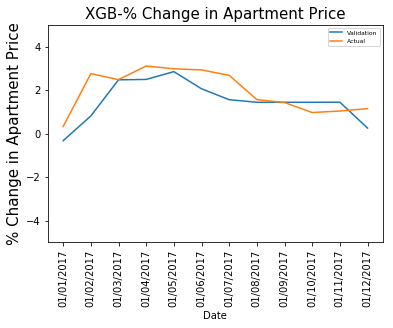

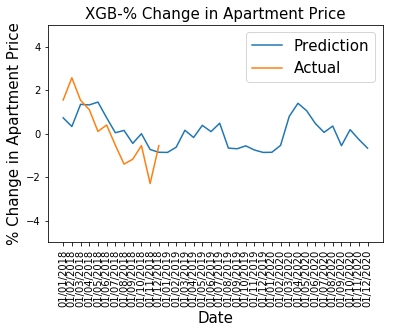

In [49]:

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

#Train/Validation/Test Split
Y_train=dep_apartment.iloc[0:144]
X_train = ind.loc[0:143,['Population Intrapolated',
        'Prime Rate', 'CPI',
        'Per capita Income', 
        'cad to usd exchange rates','no of sales']]
X_valid = ind.loc[144:155,['Population Intrapolated',
        'Prime Rate', 'CPI', 
        'Per capita Income', 
        'cad to usd exchange rates','no of sales']]
Y_valid=dep_apartment.iloc[144:156]
Y_test=dep_apartment.iloc[156:192]
X_test = ind.loc[156:191,['Population Intrapolated',
        'Prime Rate', 'CPI',
        'Per capita Income',  
        'cad to usd exchange rates','no of sales']]

#Scaling
scaler=MinMaxScaler()
norm_train=scaler.fit_transform(X_train)
norm_valid=scaler.transform(X_valid)
norm_test=scaler.transform(X_test)


#Optimum Hyperparameter Selection
learning=[.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
depth=[1,2,3,4,5,6,7,8,9,10]
valid_list=[]
pred_list=[]
parameter_list=[]
for i in learning:
    for j in depth:

    
        model=XGBRegressor(learning_rate=i,max_depth=j,n_estimators=1000,random_state=1)
        model.fit(norm_train,Y_train)
        validation=model.predict(norm_valid)
        prediction=model.predict(norm_test) 
        valid_mse=mean_squared_error(Y_valid,validation)
        test_mse=mean_squared_error(Y_test,prediction)
        parameter_list.append((i,j))
        print(i,j,valid_mse,test_mse)
        valid_list.append(valid_mse)
        pred_list.append(test_mse)
        
#Finding Parameters Corresponding to Minimum Squared Error
optimum_error_pos= valid_list.index(min(valid_list))
optimum_order=parameter_list[optimum_error_pos]
optimum_i=optimum_order[0]
optimum_j=optimum_order[1]
print('min_mse_validation:',min(valid_list))
print('optimum_learning rate:',optimum_i)
print('optimum_depth:',optimum_j)


#Rerun model with best parameter
final_model=XGBRegressor(learning_rate=optimum_i,max_depth=optimum_j,n_estimators=1000,random_state=1)
final_model.fit(norm_train,Y_train)
prediction=final_model.predict(norm_test)
validation=final_model.predict(norm_valid)



#Validation Plot
valid_df=pd.DataFrame(validation)
date_v=df.loc[144:155,['Date']]
Y_tv=dep_apartment.iloc[144:156]

plt.plot(date_v['Date'],valid_df.loc[:,:],label='Validation')
plt.plot(date_v['Date'],Y_tv.loc[:],label='Actual')
plt.xticks(date_v['Date'], rotation='vertical')
plt.xlabel('Date')
plt.ylabel('% Change in Apartment Price',fontsize=15)
plt.title('XGB-% Change in Apartment Price')
plt.ylim(-5,5)
plt.legend()
plt.show()

#Prediction plot
pred_df=pd.DataFrame(prediction)
date_p=df.loc[156:191,['Date']]
date_pa=df.loc[156:167,['Date']]
Y_tp=dep_apartment.iloc[156:168]

plt.plot(date_p['Date'],pred_df.loc[:,:],label='Prediction')
plt.plot(date_pa['Date'],Y_tp.loc[:],label='Actual')
plt.xticks(date_p['Date'], rotation='vertical')
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Change in Apartment Price',fontsize=15)
plt.title('XGB-% Change in Apartment Price')
plt.ylim(-5,5)
plt.xticks(rotation='vertical')
plt.legend(fontsize=15)
plt.show()


,pred_per_change,real_per_change,Date,pred_ap,real_ap,PCAP_sav/app_model,PCAP_sav/app_actual
0,0.724242,1.545220,01/01/2018,664880.719683,670300.0,0.724242,1.545220
1,0.324875,2.566015,01/02/2018,667040.749515,687500.0,1.051469,4.150886
2,1.344016,1.527273,01/03/2018,676005.882826,698000.0,2.409617,5.741554
3,1.318798,1.103152,01/04/2018,684921.036941,705700.0,3.760193,6.908044
4,1.448369,0.099192,01/05/2018,694841.221910,706400.0,5.263024,7.014089
5,0.724951,0.396376,01/06/2018,699878.477598,709200.0,6.026129,7.438267
6,0.039584,-0.535815,01/07/2018,700155.516945,705400.0,6.068098,6.862597
7,0.144880,-1.403459,01/08/2018,701169.904113,695500.0,6.221770,5.362824
8,-0.450361,-1.179008,01/09/2018,698012.109481,687300.0,5.743389,4.120588
9,-0.005660,-0.552888,01/10/2018,697972.603678,683500.0,5.737404,3.544917


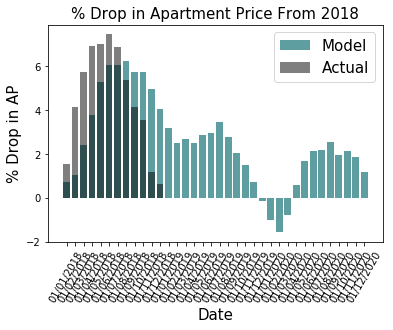

In [50]:

#Creating results Dataframe
date=df.loc[156:191,['Date']].reset_index(drop=True)
real=Y_tp.reset_index()
results=pd.concat([pred_df,real,date],axis=1,join='outer',ignore_index=True)
res=results.drop(1,axis=1)
res['pred_ap']=df.loc[155,'Apartment_Benchmark']+(df.loc[155,'Apartment_Benchmark']*(res.iloc[0:1,0])/100)
res['real_ap']=df.loc[155,'Apartment_Benchmark']+(df.loc[155,'Apartment_Benchmark']*(res.iloc[0:1,1])/100)
f_results=res.rename(columns={0:'pred_per_change',2:'real_per_change',3:'Date'})

#Looping to find the housing price each month from 2018 beginning
for i in range (1,36):
    f_results.loc[i,['pred_ap']]=f_results.loc[i-1,['pred_ap']]+(f_results.loc[i-1,['pred_ap']]*(f_results.iloc[i,0]/100))
for i in range (1,12):
    f_results.loc[i,['real_ap']]=f_results.loc[i-1,['real_ap']]+(f_results.loc[i-1,['real_ap']]*(f_results.iloc[i,1]/100))
    
#Calculating the percentage drop of increase in housing price from 2018 beginning
f_results['PCAP_sav/app_model']=((f_results['pred_ap']-df.loc[155,'Apartment_Benchmark'])/df.loc[155,'Apartment_Benchmark'])*100
f_results['PCAP_sav/app_actual']=((f_results['real_ap']-df.loc[155,'Apartment_Benchmark'])/df.loc[155,'Apartment_Benchmark'])*100

#plotting housing price percentage drop from 2018-2021
plt.bar(f_results.iloc[:,2],f_results['PCAP_sav/app_model'],label='Model',alpha=1,color='cadetblue')
plt.bar(f_results.iloc[0:12,2],f_results.iloc[0:12,6],label='Actual',alpha=0.5,color='black')
plt.xticks(rotation=60)
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Drop in AP',fontsize=15)
plt.title('% Drop in Apartment Price From 2018')
plt.legend(fontsize=15)
plt.savefig('Apartments_Result.png')


f_results.head(12)


## Apartment prices staying fairly constant for the next 2 years and seasonality of housinf prices visible here.

# Townhouse XGB

0.01 1 1.2663175062098193 0.5442879546543423
0.01 2 0.9028652711371992 0.7572111165439523
0.01 3 1.003713864562015 1.0679077179946446
0.01 4 0.8401739501191338 0.5924843899304232
0.01 5 0.6943406256230356 0.5132113863020881
0.01 6 0.6255762799132759 0.5250518784436657
0.01 7 0.6058087749504695 0.5091532309321454
0.01 8 0.6087345716423437 0.550284046541988
0.01 9 0.6002307080352641 0.5365876599079517
0.01 10 0.5909487805657 0.5516513285075565
0.1 1 3.4062517357442044 1.9184784181525696
0.1 2 1.139186143783306 1.22266722890397
0.1 3 1.0883616942449874 1.08181979117164
0.1 4 0.9249898814954949 0.7516480295733845
0.1 5 0.6988435677173265 0.5292571424630629
0.1 6 0.6263164814548083 0.5773714672405806
0.1 7 0.6178382577389544 0.5710293056450017
0.1 8 0.5626842154072645 0.46092518897282037
0.1 9 0.571141859709344 0.5312352110225722
0.1 10 0.5696163785152369 0.5266559489696614
0.2 1 4.0833160816641145 2.2948272133332424
0.2 2 1.2139940434477037 1.27912213864423
0.2 3 1.095058339717809 1.136413

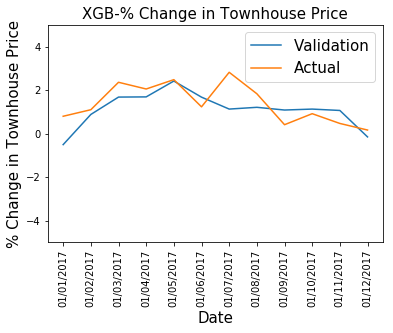

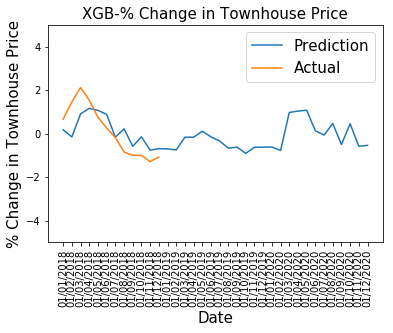

In [51]:

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

#Train/Validation/Test Split
Y_train=dep_townhouse.iloc[0:144]
X_train = ind.loc[0:143,['Population Intrapolated',
        'Prime Rate',   
        'Per capita Income', 'Unemployment',
        'cad to usd exchange rates','no of sales' ]]
X_valid = ind.loc[144:155,['Population Intrapolated',
        'Prime Rate',  
        'Per capita Income', 'Unemployment', 
        'cad to usd exchange rates','no of sales']]
Y_valid=dep_townhouse.iloc[144:156]
Y_test=dep_townhouse.iloc[156:192]
X_test = ind.loc[156:191,['Population Intrapolated',
        'Prime Rate',  
        'Per capita Income', 'Unemployment', 
        'cad to usd exchange rates','no of sales']]

#Scaling
scaler=MinMaxScaler()
norm_train=scaler.fit_transform(X_train)
norm_valid=scaler.transform(X_valid)
norm_test=scaler.transform(X_test)
learning=[.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
depth=[1,2,3,4,5,6,7,8,9,10]
valid_list=[]
pred_list=[]
parameter_list=[]

#Optimum Hyperparameter Selection
for i in learning:
    for j in depth:

    
        model=XGBRegressor(learning_rate=i,max_depth=j,n_estimators=1000,random_state=1)
        model.fit(norm_train,Y_train)
        validation=model.predict(norm_valid)
        prediction=model.predict(norm_test) 
        valid_mse=mean_squared_error(Y_valid,validation)
        test_mse=mean_squared_error(Y_test,prediction)
        parameter_list.append((i,j))
        print(i,j,valid_mse,test_mse)
        valid_list.append(valid_mse)
        pred_list.append(test_mse)
        
#Finding Parameters Corresponding to Minimum Squared Error
optimum_error_pos= valid_list.index(min(valid_list))
optimum_order=parameter_list[optimum_error_pos]
optimum_i=optimum_order[0]
optimum_j=optimum_order[1]
print('min_mse_validation:',min(valid_list))
print('optimum_learning rate:',optimum_i)
print('optimum_depth:',optimum_j)

#Rerun model with best parameter
final_model=XGBRegressor(learning_rate=optimum_i,max_depth=optimum_j,n_estimators=1000,random_state=1)
final_model.fit(norm_train,Y_train)
prediction=final_model.predict(norm_test)
validation=final_model.predict(norm_valid)



#Validation Plot
valid_df=pd.DataFrame(validation)
date_v=df.loc[144:155,['Date']]
Y_tv=dep_townhouse.iloc[144:156]

plt.plot(date_v['Date'],valid_df.loc[:,:],label='Validation')
plt.plot(date_v['Date'],Y_tv.loc[:],label='Actual')
plt.xticks(date_v['Date'], rotation='vertical')
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Change in Townhouse Price',fontsize=15)
plt.title('XGB-% Change in Townhouse Price')
plt.ylim(-5,5)
plt.xticks(rotation='vertical')
plt.legend(fontsize=15)
plt.show()

#Prediction plot
pred_df=pd.DataFrame(prediction)
date_p=df.loc[156:191,['Date']]
date_pa=df.loc[156:167,['Date']]
Y_tp=dep_townhouse.iloc[156:168]

plt.plot(date_p['Date'],pred_df.loc[:,:],label='Prediction')
plt.plot(date_pa['Date'],Y_tp.loc[:],label='Actual')
plt.xticks(date_p['Date'], rotation='vertical')
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Change in Townhouse Price',fontsize=15)
plt.title('XGB-% Change in Townhouse Price')
plt.ylim(-5,5)
plt.xticks(rotation='vertical')
plt.legend(fontsize=15)
plt.show()


,pred_per_change,real_per_change,Date,pred_thp,real_thp,PCTHP_sav/app_model,PCTHP_sav/app_actual
0,0.171460,0.663080,01/01/2018,800670.479325,804600.0,0.171460,0.663080
1,-0.154029,1.454139,01/02/2018,799437.211635,816300.0,0.017166,2.126861
2,0.904644,2.119319,01/03/2018,806669.272503,833600.0,0.921966,4.291255
3,1.160640,1.535509,01/04/2018,816031.798758,846400.0,2.093306,5.892656
4,1.068452,0.744329,01/05/2018,824750.709756,852700.0,3.184125,6.680846
5,0.883747,0.258004,01/06/2018,832039.423192,854900.0,4.096012,6.956087
6,-0.166891,-0.187156,01/07/2018,830650.820983,853300.0,3.922285,6.755911
7,0.218097,-0.843783,01/08/2018,832462.441554,846100.0,4.148936,5.855123
8,-0.583809,-1.004609,01/09/2018,827602.453725,837600.0,3.540905,4.791693
9,-0.148374,-1.002865,01/10/2018,826374.506686,829200.0,3.387277,3.740773


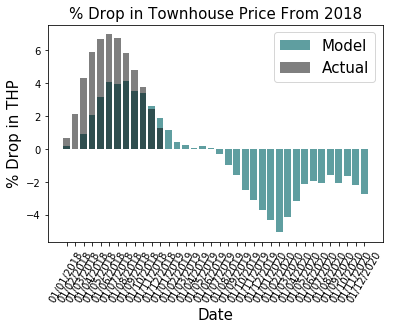

In [52]:

#Creating results Dataframe
date=df.loc[156:191,['Date']].reset_index(drop=True)
real=Y_tp.reset_index()
results=pd.concat([pred_df,real,date],axis=1,join='outer',ignore_index=True)
res=results.drop(1,axis=1)
res['pred_thp']=df.loc[155,'Townhouse_Benchmark']+(df.loc[155,'Townhouse_Benchmark']*(res.iloc[0:1,0])/100)
res['real_thp']=df.loc[155,'Townhouse_Benchmark']+(df.loc[155,'Townhouse_Benchmark']*(res.iloc[0:1,1])/100)
f_results=res.rename(columns={0:'pred_per_change',2:'real_per_change',3:'Date'})

#Looping to find the housing price each month from 2018 beginning
for i in range (1,36):
    f_results.loc[i,['pred_thp']]=f_results.loc[i-1,['pred_thp']]+(f_results.loc[i-1,['pred_thp']]*(f_results.iloc[i,0]/100))
for i in range (1,12):
    f_results.loc[i,['real_thp']]=f_results.loc[i-1,['real_thp']]+(f_results.loc[i-1,['real_thp']]*(f_results.iloc[i,1]/100))
    
#Calculating the percentage drop of increase in housing price from 2018 beginning
f_results['PCTHP_sav/app_model']=((f_results['pred_thp']-df.loc[155,'Townhouse_Benchmark'])/df.loc[155,'Townhouse_Benchmark'])*100
f_results['PCTHP_sav/app_actual']=((f_results['real_thp']-df.loc[155,'Townhouse_Benchmark'])/df.loc[155,'Townhouse_Benchmark'])*100

#plotting housing price percentage drop from 2018-2021
plt.bar(f_results.iloc[:,2],f_results['PCTHP_sav/app_model'],label='Model',alpha=1,color='cadetblue')
plt.bar(f_results.iloc[0:12,2],f_results.iloc[0:12,6],label='Actual',alpha=0.5,color='black')
plt.xticks(rotation=60)
plt.xlabel('Date',fontsize=15)
plt.ylabel('% Drop in THP',fontsize=15)
plt.title('% Drop in Townhouse Price From 2018')
plt.legend(fontsize=15)
plt.savefig('Townhouse_Result.png')


f_results.head(12)


## Townhomes are seen to depreciating by the model.